## Setup and configs

 good artcle https://www.techbriefs.com/component/content/article/tb/techbriefs/information-sciences/13857?start=1


In [ ]:
import numpy as np
import json
from os import listdir,getcwd,chdir
chdir('..\\')

from os.path import isfile,join
import sys
sys.path.append(join(getcwd(),'src\compression_funcs'))
sys.path.append(join(getcwd(),'src\DataLoader'))
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import chebyshev_compression as cheb
import Adaptive_chebyshev_tests as cheb_tests
import Company_Loader as company_data_loader
import MIT_BIH_Loader as ecg_data_loader
import REDD_Loader as power_data_loader
import scipy

getcwd()

In [2]:
%matplotlib inline

In [3]:
company_path_bin = join(getcwd(),r'Data\TheCompany')
company_path_csv = join(getcwd(),r'Data\TheCompany\csv\temp_company.csv')

mit_bih_csv = join(getcwd(),r'Data\MIT_BIH_CSV') 

gas_path_bin = join(getcwd(),r'Data\GAS')

REDD_path_csv = join(getcwd(),r'Data\REDD')

data_path = mit_bih_csv

0.20833333333333334
0.4166666666666667
0.625
0.8333333333333334


Text(0.5, 1.0, 'Sanity check total sample 31200000')

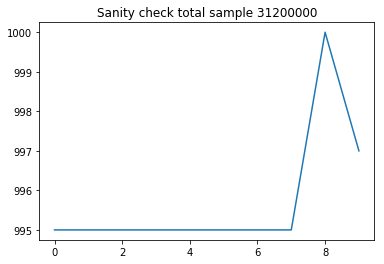

In [4]:
raw_data = ecg_data_loader.load_data(data_path)
plt.plot(raw_data[:10])
plt.title('Sanity check total sample {0}'.format(raw_data.shape[0]))

In [5]:
def calc_stats(coefs,orignal,reconstrcuted):
    dict_toReturn = {
        "block_size:":len(orignal),
        "num of zeros in coefs":np.size((np.where(coefs == 0))),
        "loss norm2":np.linalg.norm(reconstrcuted-orignal),
        "loss factor":(np.std(reconstrcuted) - np.std(orignal)) / np.std(orignal),
        "compression gain":float(len(orignal))/(len(orignal)-np.size((np.where(coefs == 0))))
    }
   
    return dict_toReturn

def print_lot_statistics(coefs,orignal,reconstrcuted):
    #statistics
    dict_toReturn = calc_stats(coefs,orignal,reconstrcuted)
    print (dict_toReturn)

    #plot
    plt.plot(orignal)
    plt.plot(reconstrcuted)
    plt.legend(('original', 'decompressed'))
    plt.title('Compressed vs decompressed block_size {0}'.format(i))
    plt.show()

    plt.plot(coefs)
    plt.title('coeficient. count={0}'.format(len(coefs)))
    plt.show()
    return dict_toReturn

## DCT - RAW

{'block_size:': 512, 'num of zeros in coefs': 0, 'loss norm2': 2.5724394843074972e-12, 'loss factor': -2.0136808820445294e-16, 'compression gain': 1.0}


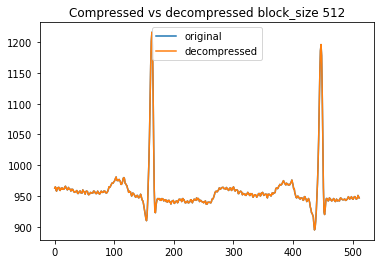

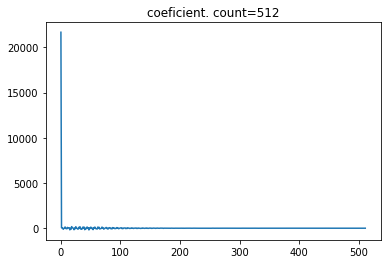

{'block_size:': 512,
 'num of zeros in coefs': 0,
 'loss norm2': 2.5724394843074972e-12,
 'loss factor': -2.0136808820445294e-16,
 'compression gain': 1.0}

In [6]:
i=512
offset = 500
company_cheb_transform_sample = raw_data[offset:offset+i]

coefs = scipy.fftpack.dct(company_cheb_transform_sample,norm = 'ortho')
company_cheb_transform_sample_reconstructed = scipy.fftpack.idct(coefs,norm = 'ortho')

print_lot_statistics(coefs,company_cheb_transform_sample,company_cheb_transform_sample_reconstructed)

## Chebyshev transform

{'block_size:': 512, 'num of zeros in coefs': 0, 'loss norm2': 2.531926094357014e-12, 'loss factor': -3.719261779638856e-16, 'compression gain': 1.0}


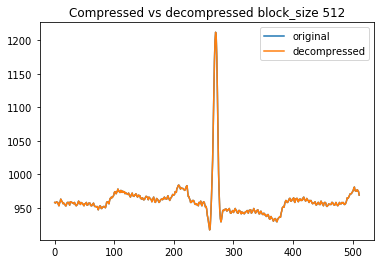

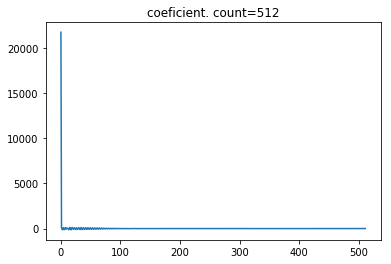

{'block_size:': 512,
 'num of zeros in coefs': 0,
 'loss norm2': 2.531926094357014e-12,
 'loss factor': -3.719261779638856e-16,
 'compression gain': 1.0}

In [7]:
#Sample a subset data
i=512
offset = 100
company_cheb_transform_sample = raw_data[offset:offset+i]

# chebyshev transofrm and back
coefs,sample_size= cheb.block_compress(company_cheb_transform_sample)
company_cheb_transform_sample_reconstructed = cheb.block_decompress(coefs)

#print plot statistics
print_lot_statistics(coefs,company_cheb_transform_sample,company_cheb_transform_sample_reconstructed)

## Chebyshev transform threshold retain

In [8]:
def evaluate_chebysehv(company_cheb_transform_sample_thres,threshold_idx=-1,print_stats=False):
    # chebyshev transofrm and back
   
    coefs,sample_size= cheb.block_compress(company_cheb_transform_sample_thres)
    
    if threshold_idx>-1:
        threshold = sorted(np.abs(coefs))[threshold_idx]
        coefs = np.where(np.abs(coefs)>threshold,coefs,0)

    company_cheb_transform_sample_thres_reconstructed = cheb.block_decompress(coefs)
    #print plot statistics
    if print_stats:
        return print_lot_statistics(coefs,company_cheb_transform_sample_thres,company_cheb_transform_sample_thres_reconstructed)
    else:
        return calc_stats(coefs,company_cheb_transform_sample_thres,company_cheb_transform_sample_thres_reconstructed)


{'block_size:': 1200, 'num of zeros in coefs': 1101, 'loss norm2': 834.6939581970985, 'loss factor': -0.04734588811064215, 'compression gain': 12.121212121212121}


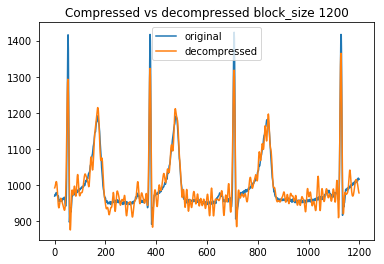

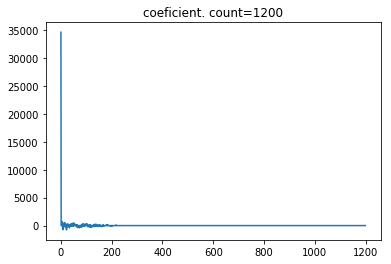

{'block_size:': 1200,
 'num of zeros in coefs': 1101,
 'loss norm2': 834.6939581970985,
 'loss factor': -0.04734588811064215,
 'compression gain': 12.121212121212121}

In [9]:
#Sample a subset data
offset = 8000000
i=1200
company_cheb_transform_sample_thres = raw_data[offset:offset+i]
evaluate_chebysehv(company_cheb_transform_sample_thres,1100,True)

In [10]:
pd.DataFrame(raw_data[offset:offset+i]).to_csv('ecg_temp.csv')

## Sliding Chebyshev

In [11]:

cheb_tests.Sens_Test_Automatic('ecg_temp.csv')

length of data 1200
window bounderies: 0 1024
window bounderies: 1024 2048
{'block_size:': 1200, 'percentage of zeros in coefs': 88.87606534090908, 'loss norm2': 686.7112435387875, 'loss factor': -3.1792931698967104, 'compression gain': 9.257473481195756}


## IoT Data Compression Sensor - Agnostic Approach ##
https://ieeexplore-ieee-org.ezprimo1.idc.ac.il/stamp/stamp.jsp?arnumber=7149287

https://infoscience.epfl.ch/record/181860/files/TKDE.pdf

https://infoscience.epfl.ch/record/181860/files/TKDE.pdf

https://www-user.tu-chemnitz.de/~potts/paper/sparse_Cheb.pdf

 - https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20080009460.pdf
 